# ATP Website and Others Scraper

In [1]:
import numpy as np

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
# headers = {'User-Agent': 
#            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'} 
import re
import json
import pandas as pd

from selenium.webdriver.firefox.service import Service as FirefoxService
from webdriver_manager.firefox import GeckoDriverManager
#from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options

In [117]:
# Setting selenium options
options = Options()
options.headless = False

In [118]:
service = FirefoxService(executable_path=GeckoDriverManager().install())

[WDM] - Downloading: 19.0kB [00:00, 9.33MB/s]                   
[WDM] - Downloading: 19.0kB [00:00, 19.5MB/s]                   
[WDM] - Downloading: 100%|██████████| 1.58M/1.58M [00:00<00:00, 4.82MB/s]


In [119]:
driver = webdriver.Firefox(service=service, options=options)
#driver = webdriver.Chrome(ChromeDriverManager().install())

### Create a Match Info DF per Player

In [ ]:
url = #Player Page
driver.get(url)

In [221]:
tournaments = driver.find_elements(By.XPATH, "//div[@class='activity-tournament-table']")

df_list = []

for tourn in tournaments[:]:
    # Tournament 
    info = tourn.find_elements(By.TAG_NAME, "table")[0]
    # Tournament Info
    if len(info.text.split('\n')) != 9:
        continue
    else:
        tourn_name, tourn_loc, tourn_dates, tourn_size, tourn_surf, _ , tourn_prize,_,_ = info.text.split('\n')

    # Match and Opponent Info
    # Elements containing row info of each match
    matches = tourn.find_elements(By.TAG_NAME, "table")[2]
    
    # List of Opponent Names
    match_opp = matches.text.split('\n')[2::3]
    # Find all indexes within the list that correspond to "Bye"
    bye_indices = [i for i, x in enumerate(match_opp) if x == "Bye"]
    
    # Contains Match Round and Opp Rank per list item e.g. Final 2
    match_round_rank = matches.text.split('\n')[1::3]
    # Remove any round info that corresponds to a "Bye" row
    for ind in bye_indices[::-1]:
        del match_round_rank[ind]
    match_round = [' '.join(x.split(' ')[:-1]) for x in match_round_rank] 
    opp_ranks = [x.split(' ')[-1] for x in match_round_rank] 

    match_score = matches.text.split('\n')[3::3]
    # Reformat Scores from 'W 64 64' to separate outcome 'W' and score '64 64'.
    match_result = [x.split(' ')[0] for x in match_score]
    match_scores = [" ".join(x.split(' ')[1:]) for x in match_score]
    # Number of Sets
    n_sets = [len(x.split(' (RET)')[0].split(' '))  for x in match_scores]
    # Match Page Links 
    match_links = []
    for i,match in enumerate(matches.find_elements(By.TAG_NAME, "tr")[1:]):
        if match_opp[i] == "Bye":
            pass
            #match_links.append(None)
        else:
            match_links.append(match.find_elements(By.TAG_NAME, "td")[4].find_elements(By.TAG_NAME, "a")[0].get_attribute("href"))
    #match_links = [x.find_elements(By.TAG_NAME, "td")[4].find_elements(By.TAG_NAME, "a")[0].get_attribute("href") for x in matches.find_elements(By.TAG_NAME, "tr")[1:]]
    
    match_opp = list(filter(('Bye').__ne__, match_opp))

    #

    df = pd.DataFrame({'Tournament':[tourn_name]*len(match_opp), 'Location':[tourn_loc]*len(match_opp), 'Dates':[tourn_dates]*len(match_opp),
     'Draw':[tourn_size]*len(match_opp), 'Surface':[tourn_surf]*len(match_opp), 
    'Round': match_round, 'Opponent': match_opp, 'Rank': opp_ranks, 'Results': match_result, 
     'Sets': n_sets, 'Score': match_scores, 'URL': match_links})

    df_list.append(df)

In [230]:
df_matches = pd.concat(df_list).reset_index(drop=True)

In [303]:
df_matches.to_csv('Charlie_2022.csv', header=False)

### Retrieve Match Statistics

In [309]:
driver.close()

In [304]:
url = df_matches.URL.iloc[10]

In [244]:
driver.quit() 

In [298]:
# Return the Left Column Player in the Match Stats Page
player_L = ' '.join(driver.find_elements(By.XPATH, "//div[@class='player-left-name']")[0].text.split('n'))
# Return the Right Column Player in the Match Stats Page
player_R = ' '.join(driver.find_elements(By.XPATH, "//div[@class='player-right-name']")[0].text.split('n'))
player_L, player_R

('Mackenzie McDonald', 'Carlos Alcaraz')

In [299]:
# Serve Speeds (km/h)
# For "L" Player 1
serve_max_L, serve1_avg_L, serve2_avg_L = [ x.text.split('\nkm/h')[0] for x in driver.find_elements(By.XPATH, "//div[contains(@class, 'speedkmh1')]")[::2] ]
# For "R" Player 2
serve_max_R, serve1_avg_R, serve2_avg_R = [ x.text.split('\nkm/h')[0] for x in driver.find_elements(By.XPATH, "//div[contains(@class, 'speedkmh2')]")[::2] ]
serve_max_R, serve1_avg_R, serve2_avg_R

('217', '192', '155')

In [300]:
serve_rating, aces, dfs, serve1_p, serve1_w, serve2_w, \
bp_saved, serve_gp, return_rating, ret1_w, ret2_w, bp_con, ret_gp, \
netp_w, winners, ufes, servep_w, retp_w, totp_w = \
[ x.text for x in driver.find_elements(By.XPATH, "//div[contains(@class, 'player2 non-speed')]")[::2] ]

In [278]:
driver.quit()

In [312]:
 import time
 from random import randint

In [315]:
df_matches.Tournament.unique()

array(['US Open', 'ATP Masters 1000 Cincinnati',
       'ATP Masters 1000 Canada', 'Umag', 'Hamburg', 'Wimbledon',
       'Roland Garros', 'ATP Masters 1000 Madrid', 'Barcelona',
       'ATP Masters 1000 Monte Carlo', 'ATP Masters 1000 Miami',
       'ATP Masters 1000 Indian Wells', 'Rio de Janeiro',
       'Australian Open'], dtype=object)

In [316]:
slams = ['US Open', 'Wimbledon', 'Roland Garros', 'Australian Open']

In [344]:
serve_maxs = []
serve1_avgs = []
serve2_avgs = []
opps = []
for url in df_matches[~df_matches.Tournament.isin(slams)].URL.iloc[:]:

    service = FirefoxService(executable_path=GeckoDriverManager().install())
    driver = webdriver.Firefox(service=service, options=options)
    driver.get(url)

    # Return the Left Column Player in the Match Stats Page
    player_L = ' '.join(driver.find_elements(By.XPATH, "//div[@class='player-left-name']")[0].text.split('\n'))
    # Return the Right Column Player in the Match Stats Page
    player_R = ' '.join(driver.find_elements(By.XPATH, "//div[@class='player-right-name']")[0].text.split('\n'))

    if player_L == 'Carlos Alcaraz':
        p_num = '1'
        opp = player_R
    else:
        p_num = '2'
        opp = player_L


    # Get Service Stats
    try:
        serve_max, serve1_avg, serve2_avg = [ x.text.split('\nkm/h')[0] for x in driver.find_elements(By.XPATH, f"//div[contains(@class, 'speedkmh{p_num}')]")[::2] ]
    except:
        time.sleep(5)
        try:
            serve_max, serve1_avg, serve2_avg = [ x.text.split('\nkm/h')[0] for x in driver.find_elements(By.XPATH, f"//div[contains(@class, 'speedkmh{p_num}')]")[::2] ]
        except:
            continue
        
    serve_maxs.append(serve_max)
    serve1_avgs.append(serve1_avg)
    serve2_avgs.append(serve2_avg)
    opps.append(opp)

    driver.quit()

    time.sleep(randint(1,3))


[WDM] - Downloading: 16.2kB [00:00, 2.37MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 3.31MB/s]                   
[WDM] - Downloading: 100%|██████████| 1.42M/1.42M [00:00<00:00, 4.28MB/s]
[WDM] - Downloading: 16.2kB [00:00, 4.22MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 4.15MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 5.50MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 5.48MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 6.55MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 7.50MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 5.53MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 3.57MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 5.48MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 3.66MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 4.15MB/s]                   
[WDM] - Downloading: 16.2kB [00:00, 6.39MB/s]                   
[WDM] - Download

In [336]:
serve_max, serve1_avg, serve2_avg = [ x.text.split('\nkm/h')[0] for x in driver.find_elements(By.XPATH, f"//div[contains(@class, 'speedkmh{p_num}')]")[::2] ]

In [348]:
opps

['Cameron Norrie',
 'Marin Cilic',
 'Mackenzie McDonald',
 'Tommy Paul',
 'Alexander Zverev',
 'Novak Djokovic',
 'Sebastian Korda',
 'Casper Ruud',
 'Hubert Hurkacz',
 'Miomir Kecmanovic',
 'Stefanos Tsitsipas',
 'Marin Cilic',
 'Marton Fucsovics',
 'Rafael Nadal',
 'Cameron Norrie',
 'Gael Monfils',
 'Roberto Bautista Agut',
 'Mackenzie McDonald']

In [350]:
import matplotlib.pyplot as plt

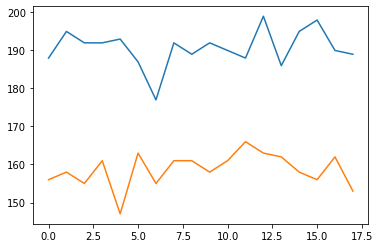

In [361]:
plt.plot(np.arange(len(serve1_avgs)), [ int(x) for x in serve1_avgs ])
plt.plot(np.arange(len(serve1_avgs)), [ int(x) for x in serve2_avgs ])

In [363]:
len(serve2_avgs)

18

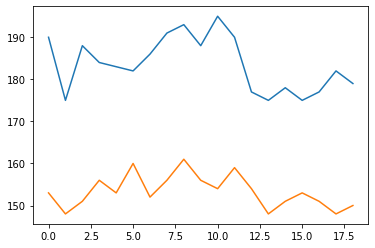

In [367]:
plt.plot(np.arange(len(serve1_avg_gs)), [ int(x) for x in serve1_avg_gs ])
plt.plot(np.arange(len(serve1_avg_gs)), [ int(x) for x in serve2_avg_gs ])

In [365]:
# Charlie Stats Slams

serve_max_gs = [211, 206, 216, 209, 215, 212, 214, 214, 214, 217, 214, 214, 209, 206, 217, 212, 209, 208, 206]
serve1_avg_gs = [190, 175, 188, 184, 183, 182, 186, 191, 193, 188, 195, 190, 177, 175, 178, 175, 177, 182, 179]
serve2_avg_gs = [153, 148, 151, 156, 153, 160, 152, 156, 161, 156, 154, 159, 154, 148, 151, 153, 151, 148, 150]

In [390]:
serve_maxs

['215',
 '219',
 '217',
 '220',
 '221',
 '222',
 '211',
 '218',
 '220',
 '222',
 '215',
 '220',
 '223',
 '223',
 '219',
 '218',
 '216',
 '218']

In [391]:
serve_max_all = serve_max_gs[:3]+ serve_maxs[:14]+ serve_max_gs[3:12] + serve_maxs[14:] + serve_max_gs[12:]
serve_1s_all = serve1_avg_gs[:3]+ serve1_avgs[:14]+ serve1_avg_gs[3:12] + serve1_avgs[14:] + serve1_avg_gs[12:]
serve_2s_all = serve2_avg_gs[:3]+ serve2_avgs[:14]+ serve2_avg_gs[3:12] + serve2_avgs[14:] + serve2_avg_gs[12:]

In [406]:
pd.DataFrame({'Max': serve_max_all,'1st_Avg': serve_1s_all,'2_Avg': serve_2s_all}).to_csv("Charlie_Serves_2022.csv", index=False)

In [396]:
# Set figure styling elements
import matplotlib as mpl

mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.color'] = 'white'
mpl.rcParams['ytick.labelsize'] = 13

mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['axes.labelsize'] = 16

mpl.rc('font', family='Arial')

Text(0, 0.5, 'Speed (Km/h)')

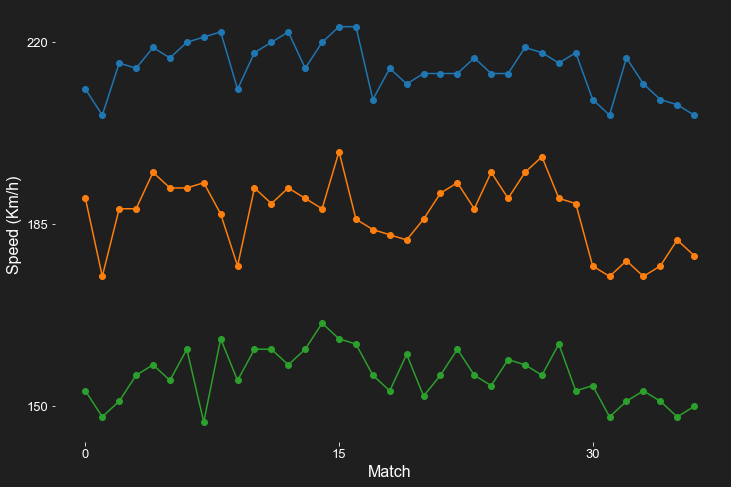

In [403]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
fig.set_facecolor('#1f1f1f')

ax.set_facecolor('#1f1f1f')

ax.plot(np.arange(len(serve_max_all)), [ int(x) for x in serve_max_all ], marker='o')
ax.plot(np.arange(len(serve_1s_all)), [ int(x) for x in serve_1s_all ], marker='o')
ax.plot(np.arange(len(serve_2s_all)), [ int(x) for x in serve_2s_all ], marker='o')

ax.set_xticks([0,15,30])
ax.set_yticks([150,185,220])

ax.set_xlabel("Match")
ax.set_ylabel("Speed (Km/h)")

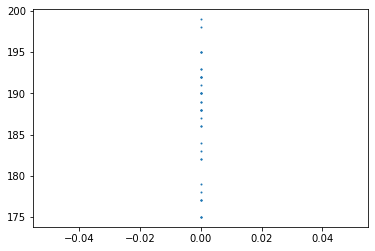

In [379]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))\
fig.set_facecolor('#1f1f1f')
ax.set_facecolor('#1f1f1f')
ax.plot(np.arange(len(serve_max_all2)), [ int(x) for x in serve_max_all2 ], marker='o', mfc='w', mew=3, ms=10, lw=3, c="#1DA2DC\")
ax.plot(np.arange(len(serve_1s_all2)), [ int(x) for x in serve_1s_all2 ], marker='o', mfc='w', mew=3, ms=10, lw=3, c=\"#22AF4B\")
ax.plot(np.arange(len(serve_2s_all2)), [ int(x) for x in serve_2s_all2 ], marker='o', mfc='w', mew=3, ms=10, lw=3, c=\"#EE2524\")
ax.set_xticks([0,14,29])
ax.set_xticklabels([1,15,30])
ax.set_yticks([150,185,220])
ax.set_xlabel(\"Match\")
ax.set_ylabel(\"Km/h\")
ax.axhline(np.mean([ int(x) for x in serve_max_all2 ]), color='#1DA2DC', alpha=1, zorder=0, ls='--',lw=2)
ax.axhline(np.mean([ int(x) for x in serve_1s_all2 ]), color='#22AF4B', alpha=1, zorder=0, ls='--',lw=2)
ax.axhline(np.mean([ int(x) for x in serve_2s_all2 ]), color='#EE2524', alpha=1, zorder=0, ls='--',lw=2)\n",
ax.axvspan(-0.5, 17, facecolor='#1DA2DC', alpha=0.2, zorder=0)
ax.axvspan(17, 22, facecolor='#EE573D', alpha=0.2, zorder=0)
ax.axvspan(22, 28, facecolor='#91C13E', alpha=0.2, zorder=0)
ax.axvspan(28, 36.5, facecolor='#1DA2DC', alpha=0.2, zorder=0)
ax.axvline(-0.4, color='#1DA2DC', alpha=1, zorder=0)
ax.axvline(17, color='#EE573D', alpha=1, zorder=0)
ax.axvline(22, color='#91C13E', alpha=1, zorder=0)
ax.axvline(28, color='#1DA2DC', alpha=1, zorder=0)
ax.annotate(\"Hard Court\\nJan-Apr\", (0,222), color='w', alpha=1, zorder=0, fontsize=15, weight=\"bold\")
ax.annotate(\"Clay\\nMay-Jun\", (17.5,222), color='w', alpha=1, zorder=0, fontsize=15, weight=\"bold\")
ax.annotate(\"Grass\\nJun\", (22.5,222), color='w', alpha=1, zorder=0, fontsize=15, weight=\"bold\")
ax.annotate(\"Hard Court\\nAug-Sep\", (28.5,222), color='w', alpha=1, zorder=0, fontsize=15, weight=\"bold\")
ax.annotate(f\"Avg:\\n{int(np.round( np.mean([ int(x) for x in serve_max_all2 ]),0 ))}\", (34,212), color='#1DA2DC', alpha=1, zorder=0, fontsize=16, weight=\"bold\")
ax.annotate(f\"{int(np.round( np.mean([ int(x) for x in serve_1s_all2 ]),0 ))}\", (34,196), color='#22AF4B', alpha=1, zorder=0, fontsize=16, weight=\"bold\")
ax.annotate(f\"{int(np.round( np.mean([ int(x) for x in serve_2s_all2 ]),0 ))}\", (34,154), color='#EE2524', alpha=1, zorder=0, fontsize=16, weight=\"bold\")
ax.set_xlim(-0.5,36.5)
ax.set_ylim(130,230)
# You can use the wrapper around the class\n",
HighlightText(x=0.07, y=0.925,
            s=f'<Max>, average <First> and <Second> serve speeds',
        highlight_textprops=[{\"color\": \"#1DA2DC\"},
                            {\"color\": \"#22AF4B\"},
                            {\"color\": \"#EE2524\"}], fontsize=18, color='w',
        annotationbbox_kw={'boxcoords': fig.transFigure})
fig.suptitle(\"Daniil Medvedev | 2022 Season\", c='w', weight=\"bold\", fontsize=24, x=0.07, ha='left')
ax.annotate(f\"Data: Infosys + IBM\", (0.985,0.045), xycoords=\"axes fraction\", color='w', alpha=0.7, zorder=0, fontsize=13, ha='right')
ax.annotate(f\"Only Matches with available data\", (0.985,0.01), xycoords=\"axes fraction\", color='w', alpha=0.7, zorder=0, fontsize=13, ha='right')"

In [ ]:
def get_match_stats(url):
    

### Scraping Charlie's serves

In [120]:
url = "https://www.atptour.com/en/scores/stats-centre/archive/2022/422/MS006?tab=CourtVision"

In [121]:
driver.get(url)

In [11]:
#driver.find_elements(By.XPATH, "//div[@data-test='toggle-btn']")[0]

<selenium.webdriver.remote.webelement.WebElement (session="d75a1dc2-a4f8-406f-ae6c-398659883628", element="abd62415-4409-4bd9-b0f4-9209207ec8db")>

In [122]:
# Click the 2D-view button
driver.find_elements(By.XPATH, "//button[@class='button-wrapper-MC toggle-btn-wrapper first-btn ']")[0].click()

In [21]:
from selenium.webdriver.support.ui import WebDriverWait
#from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC

In [123]:
# Click on the shot type dropdown then select the required serve stat or other
driver.find_elements(By.XPATH, "//div[@class='select-arrow']")[-1].click()
WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH, "//div[text()='First serve (87)']"))).click()

In [125]:
players_div = driver.find_elements(By.XPATH, "//div[@class='playersDiv']")[0]
#WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH, "//div[text()='First serve (87)']"))).click()

In [126]:
# Click on Charlie's Name
player_button = players_div.find_elements(By.XPATH, ".//span[@class='playerName']")[1]
player_button.click()

In [347]:

driver.find_elements(By.XPATH, "//*[name()='svg']/*[name()='g'][starts-with(@class, 'court-ball-')]")

[]

In [165]:
import matplotlib.pyplot as plt

In [327]:
ball_html = driver.find_element(By.CSS_SELECTOR, '.court-ball-1_13_1_1 > use:nth-child(1)').get_attribute('outerHTML')
x, y = float(ball_html.split('<use x="')[1].split('" y="')[0]), float(ball_html.split('y="')[1].split("\"")[0])
outcome = ball_html.split('href="#')[-1].split("\"")[0]

In [ ]:
x,y,outcome

(-226.76264921081884, -127.15087286698778, 'Lost')

#### Can we try to click on each serve location to get the info of speed + rally length

In [459]:
# This successfully clicks elements on the top points timeline, which then highlights the related ball-spot on the court.
driver.find_element(By.CSS_SELECTOR, "#point-1_3_4_1 > text:nth-child(2)").click()

In [362]:
# import Action chains 
from selenium.webdriver.common.action_chains import ActionChains

In [ ]:
find_ball = driver.find_element(By.CSS_SELECTOR, ".court-ball-1_13_1_1")
#find_ball = driver.find_element(By.CSS_SELECTOR, "#Winner > text:nth-child(2)")

In [538]:
driver.find_element(By.CSS_SELECTOR, '.court-ball-1_13_1_1').location

{'x': 79, 'y': 1450}

In [537]:
driver.find_element(By.CSS_SELECTOR, '.court-ball-1_13_1_1 > use:nth-child(1)').location

{'x': 223, 'y': 1369}

In [552]:
driver.find_element(By.CSS_SELECTOR, "#Lost > circle:nth-child(1)").location

''

In [525]:
223-79, 1369-1450

(144, -81)

In [557]:
driver.find_element(By.CSS_SELECTOR, '.court-ball-1_13_1_1 > use:nth-child(1)').shadow_root

AssertionError: This only currently works in Chromium based browsers

In [487]:
action = webdriver.common.action_chains.ActionChains(driver)

In [551]:
# This was actually successful in clicking but got the wrong ball...
action.move_to_element_with_offset(find_ball, 144, -81)
action.click()
action.perform()

In [550]:
element = driver.find_element(By.CSS_SELECTOR, ".court-ball-1_13_1_1 > use:nth-child(1)")
action.move_to_element( element )
action.click()
action.perform()

In [517]:
driver.maximize_window()

In [501]:
element = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#Lost")))
element.location_once_scrolled_into_view
#element.click()

{'x': 17, 'y': 531}

In [558]:
driver.close()

#### Getting the reference service box location

In [220]:
servebox_html = driver.find_elements(By.CSS_SELECTOR, "#serviceBox")[0].get_attribute('outerHTML')
box_x, box_y = float(servebox_html.split(' width="')[1].split('" height="')[0]), float(servebox_html.split(' height="')[1].split('" stroke="')[0])

In [221]:
box_x, box_y

(161.48203038162285, 103.70174138569841)

In [329]:
x_list = [ float(ball.get_attribute('outerHTML').split('<use x="')[1].split('" y="')[0]) for ball in driver.find_elements(By.CSS_SELECTOR, "g[class^='court-ball-']") ]
y_list = [ float(ball.get_attribute('outerHTML').split('y="')[1].split("\"")[0])  for ball in driver.find_elements(By.CSS_SELECTOR, "g[class^='court-ball-']") ]

# ["Ace", "Won", "Lost" outcomes]
outcomes = [ ball.get_attribute('outerHTML').split('href="#')[-1].split("\"")[0]  for ball in driver.find_elements(By.CSS_SELECTOR, "g[class^='court-ball-']") ]

In [331]:
#outcomes

In [226]:
import os
import numpy as np
import pandas as pd


# Matplotlib for drawing the court
import matplotlib.pyplot as plt

import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection
import matplotlib.colors
from matplotlib.colors import to_rgba_array
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerLineCollection

from highlight_text import HighlightText, ax_text, fig_text

## Helper Functions

In [227]:
def createTennisCourt(linecolor='white', ax=None, lw=1, alp=1, court_xlims=(-13,13), court_ylims=(-15,15)):
    '''
    Plots a Tennis Court with adjustable line colour, width and court limits
    '''
    if ax is None:
        ax = plt.gca()

    # Court Dimensions
    width_doub = 10.97
    width_sing = 8.23
    length_half = 11.89
    length_service = 6.4

    # Baseline Bottom
    ax.plot([-width_doub/2,width_doub/2], [-length_half]*2, color=linecolor, linewidth=lw, alpha=alp)
    # Baseline Top
    ax.plot([-width_doub/2,width_doub/2], [length_half]*2, color=linecolor, linewidth=lw, alpha=alp)
    # Horizontal Center Line
    ax.plot([-width_doub/2,width_doub/2], [0]*2, color=linecolor, linewidth=lw, alpha=alp)

    # Service Line Bottom
    ax.plot([-width_sing/2,width_sing/2], [-length_service]*2, color=linecolor, linewidth=lw, alpha=alp)
    # Service Line Top
    ax.plot([-width_sing/2,width_sing/2], [length_service]*2, color=linecolor, linewidth=lw, alpha=alp)


    ax.plot([-width_doub/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)
    ax.plot([width_doub/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)

    ax.plot([-width_sing/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)
    ax.plot([width_sing/2]*2, [-length_half,length_half], color=linecolor, linewidth=lw, alpha=alp)

    ax.plot([0]*2, [-length_service,length_service], color=linecolor, linewidth=lw, alpha=alp)


    # ax.set_xlim(-width_doub/2-6.41,width_doub/2+6.41)
    # ax.set_ylim(-length_half-9,length_half+9)
    #plt.gca().invert_yaxis()

    ax.set_xlim(court_xlims)
    ax.set_ylim(court_ylims)

In [244]:
from collections import namedtuple
from scipy.stats import binned_statistic_2d

def calc_binstat(x, y, bins, pitch_range):
    '''
    For Heatmap binning purposes
    '''

    _BinnedStatisticResult = namedtuple('BinnedStatisticResult',
                                        ('statistic', 'x_grid', 'y_grid', 'cx', 'cy'))

    x = np.ravel(x)
    y = np.ravel(y)

    values = np.ravel(x)

    #bins = (3,1)
    statistic = 'count'
    #pitch_range = [[-8.23/2, 0], [0,6.4]]
    statistic, x_edge, y_edge, _ = binned_statistic_2d(x, y, values, statistic=statistic,
                                                        bins=bins, range=pitch_range)

    statistic = statistic.T
    statistic = statistic / statistic.sum()

    x_grid, y_grid = np.meshgrid(x_edge, y_edge)

    cx, cy = np.meshgrid(x_edge[:-1] + 0.5 * np.diff(x_edge),
                            y_edge[:-1] + 0.5 * np.diff(y_edge))

    stats = _BinnedStatisticResult(statistic, x_grid, y_grid, cx, cy)._asdict()

    return stats

In [254]:
# Set figure styling elements
import matplotlib as mpl

mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['xtick.color'] = '#1f1f1f'
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.color'] = '#1f1f1f'
mpl.rcParams['ytick.labelsize'] = 13

mpl.rc('font', family='Calibri')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
C:\Users\lgjg1\AppData\Local\Temp\ipykernel_39608\96964975.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


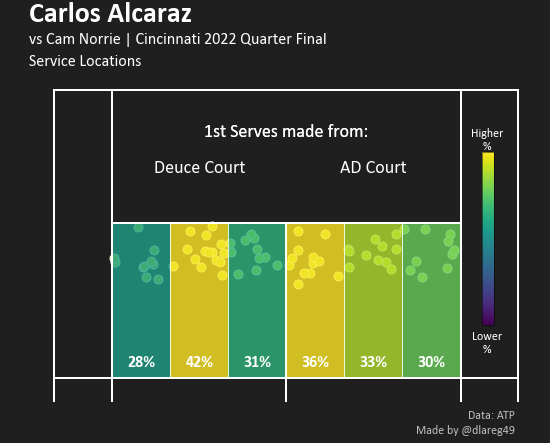

In [284]:
fig, ax = plt.subplots(1,1, figsize=(8, 6), facecolor="#1f1f1f", squeeze=True)

#data_list = [data_1st, data_2nd]
serves = ['1st', '2nd']

ax.set_facecolor("#1f1f1f")

createTennisCourt(ax=ax, lw=2, court_xlims=(-6,6), court_ylims=(-1,12))
# data_plot  = data_list[x]

# Transformed XY Data
x_trans = (np.array(y_list)*1/box_y)*8.23/2
y_trans = (np.array(x_list)*-1/box_x)*6.4

ax.scatter(x_trans, y_trans, zorder=0, \
    ec='w', s=80, c=cm.viridis(0.9), alpha=1, lw=1)

xend_deu = x_trans[x_trans<0]
yend_deu = y_trans[x_trans<0]

# Ad Court Serves
xend_ad = x_trans[x_trans>0]
yend_ad = y_trans[x_trans>0]

xends = [xend_deu, xend_ad]
yends = [yend_deu, yend_ad]
starts = ["Deuce", "AD"]
x_bounds  = [[-8.23/2, 0], [0, 8.23/2]]


for z in range(2):

    # Compute binned service hit points (split into third zones)
    stats = calc_binstat(xends[z], yends[z], (3,1), [x_bounds[z], [0,6.4]])

    ax.pcolormesh(stats['x_grid'], stats['y_grid'], stats['statistic'], ec='w',alpha=0.8, vmin=0.1)

    ax.annotate(f"{starts[z]} Court", (stats['cx'][0][1], 8.5), c='white', ha='center', fontsize=18)

    for i, ratio in enumerate(stats['statistic'][0]):
        ratio = int(np.round(ratio*100))
        ax.annotate(f"{ratio}%", (stats['cx'][0][i], 0.5), c='white', ha='center', fontsize=16, weight='bold')

    ax.annotate(f"1st Serves made from:", (0, 10), fontsize=18, c='w', ha='center')


# Figure Title
# # Data source credit
ax.annotate(f'Carlos Alcaraz', (0.05, 0.975), xycoords = 'figure fraction', fontsize=28, color='w', ha='left', weight='bold')

ax.annotate(f'vs Cam Norrie | Cincinnati 2022 Quarter Final', (0.05, 0.925), xycoords = 'figure fraction', fontsize=16, color='w', ha='left')
ax.annotate('Service Locations', (0.05, 0.875), xycoords = 'figure fraction', fontsize=16, color='w', ha='left')

ax.annotate('Data: ATP', (0.95, -0.05), xycoords = 'axes fraction', fontsize=12, color='w', alpha=0.7, ha='right')
ax.annotate('Made by @dlareg49', (0.95, -0.1), xycoords = 'axes fraction', fontsize=12, color='w', alpha=0.7, ha='right')

cbar_axes_loc = [0.875, 0.285, 0.02, 0.4]
norm = mpl.colors.Normalize(vmin=5, vmax=10)

cbaxes = fig.add_axes(cbar_axes_loc)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'),
            cax=cbaxes, orientation='vertical', label='')
cb.ax.tick_params(length=0)

cb.outline.set_linewidth(0.5)

ax.annotate('Higher\n%', (0.845, 0.68), xycoords = 'figure fraction', fontsize=12, color='w', ha='center')
ax.annotate('Lower\n%', (0.845, 0.21), xycoords = 'figure fraction', fontsize=12, color='w', ha='center')

plt.tight_layout()


In [252]:
import matplotlib as mpl

In [285]:
fig.savefig('charlie_serves.png', bbox_inches='tight', dpi=150, facecolor=fig.get_facecolor())